In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import os

In [32]:
DATA_PATH = os.environ.get("RESEARCH_DATA_PATH")

In [33]:
# Define the start and end dates for the data range
start_date = '1985-01-31'
end_date = '2018-12-31'

# Specify the proportion of test data (e.g., 10%)
test_data_size = 0.1

# Set the number of splits for K-Fold Cross Validation
KFold_split = 5

# Specify a range of alpha values for Ridge regression
alphas = [10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10**1, 10**2, 10**3, 10**4]

In [93]:
# Upload X and y data
X_mef = pd.read_csv(f'{DATA_PATH}/processed/mef_monthly_data_processed.csv')
X_mai = pd.read_csv(f'{DATA_PATH}/processed/mai_monthly_data_processed.csv')
y_mkt = pd.read_csv(f'{DATA_PATH}/processed/mkt_monthly_data_processed.csv')

X_mef['date'] = pd.to_datetime(X_mef['date'])
X_mai['date'] = pd.to_datetime(X_mai['date'])
y_mkt['date'] = pd.to_datetime(y_mkt['date'])

X_mef = X_mef[(X_mef['date'] >= start_date) & (X_mef['date'] <= end_date)]
X_mai = X_mai[(X_mai['date'] >= start_date) & (X_mai['date'] <= end_date)]
y_mkt = y_mkt[(y_mkt['date'] >= start_date) & (y_mkt['date'] <= end_date)]

# Drop the 'date' column from each dataset
X_mef = X_mef.drop('date', axis=1)
X_mai = X_mai.drop('date', axis=1)
y_mkt = y_mkt.drop('date', axis=1)

# Drop the 'GSPCprem' colum from y_mkt
y_mkt = y_mkt.drop('GSPCprem', axis=1)

X_mef = X_mef.values
X_mai = X_mai.values
y_mkt = y_mkt.values

In [80]:
def split_data(X, y, train_size, indices):
    # Split indices into train and test indices
    train_indices, test_indices = indices[:train_size], indices[train_size:]

    # Split data based on the indices
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]

    return X_train, y_train, X_test, y_test

In [81]:
def find_optimal_ridge_hyperparameters(X_train, y_train, alphas, KFold_split):
    optimal_degree = None
    optimal_alpha = None
    minimal_mse = float('inf')

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)

    for alpha in alphas:
        kf = KFold(n_splits=KFold_split)
        mse_arr = []

        for train_index, test_index in kf.split(X_train_std):
            X_train_n, y_train_n = X_train_std[train_index], y_train[train_index]
            X_train_v, y_train_v = X_train_std[test_index], y_train[test_index]

            # Train Ridge regression
            ridge = Ridge(alpha=alpha)
            ridge.fit(X_train_n, y_train_n)

            # Predict and calculate MSE on the validation set
            y_pred = ridge.predict(X_train_v)
            mse = mean_squared_error(y_train_v, y_pred)
            mse_arr.append(mse)

        # Calculate the average MSE across KFold splits
        avg_mse = np.mean(mse_arr)

        # Update optimal hyperparameters if the current setup is better
        if avg_mse < minimal_mse:
            optimal_alpha = alpha
            minimal_mse = avg_mse

    return optimal_alpha, minimal_mse

In [82]:
def train_and_evaluate_ridge(X_train, y_train, X_test, y_test, alpha):
    # Standardize both training and test data
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    # Train Ridge regression on the entire training set
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_std, y_train)

    # Predict on the training and test sets
    y_pred_train = ridge.predict(X_train_std)
    y_pred_test = ridge.predict(X_test_std)

    # Calculate and print MSE for the training and test sets
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    return mse_train, mse_test

In [83]:
def predict_with_ridge(model, scaler, new_X):
    # Standardize the new_X using the same scaler used for training
    new_X_std = scaler.transform(new_X.reshape(1, -1))

    # Predict the target value using the trained Ridge model
    predicted_y = model.predict(new_X_std)

    return predicted_y[0]

In [84]:
# Get same random split of MEF and MAI data
N = X_mef.shape[0]
train_size = int((1-test_data_size) * N)
indices = np.random.permutation(N)

In [92]:
# Training and evaluating Ridge model: MEF
print('MEF Linear Predictor')

# Split data into training and test sets
X_train, y_train, X_test, y_test = split_data(X_mef, y_mkt, train_size, indices)

# Standardize both training and test data using a scaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Find optimal alpha using cross-validation
optimal_alpha, minimal_mse = find_optimal_ridge_hyperparameters(X_train_std, y_train, alphas, KFold_split)
optimal_alpha=0
print(f"Optimal alpha: {optimal_alpha}, Minimal MSE: {minimal_mse}")

# Train and evaluate Ridge model with optimal alpha
ridge_model = Ridge(alpha=optimal_alpha)
ridge_model.fit(X_train_std, y_train)

# Evaluate the model on the test set
mse_train, mse_test = train_and_evaluate_ridge(X_train_std, y_train, X_test_std, y_test, optimal_alpha)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")
print("")

# Save the trained model and scaler for later use
ridge_scaler = scaler


MEF Linear Predictor
Optimal alpha: 0, Minimal MSE: 27949.87469523477
Train MSE: 27195.153902722544
Test MSE: 62375.21588941253



               credit_rating       gdp  house_mkt  inflation  monetary  \
credit_rating       1.000000  0.130262   0.138936   0.068397  0.143994   
gdp                 0.130262  1.000000   0.114612   0.182708  0.173876   
house_mkt           0.138936  0.114612   1.000000   0.088070  0.172920   
inflation           0.068397  0.182708   0.088070   1.000000  0.355139   
monetary            0.143994  0.173876   0.172920   0.355139  1.000000   
oil                 0.130550  0.104932   0.102429   0.299700  0.244409   
unemp               0.095210  0.191842   0.091051   0.121501  0.176362   
usd                 0.087678  0.097972   0.017893   0.201474  0.201177   

                    oil     unemp       usd  
credit_rating  0.130550  0.095210  0.087678  
gdp            0.104932  0.191842  0.097972  
house_mkt      0.102429  0.091051  0.017893  
inflation      0.299700  0.121501  0.201474  
monetary       0.244409  0.176362  0.201177  
oil            1.000000 -0.012025  0.260684  
unemp      

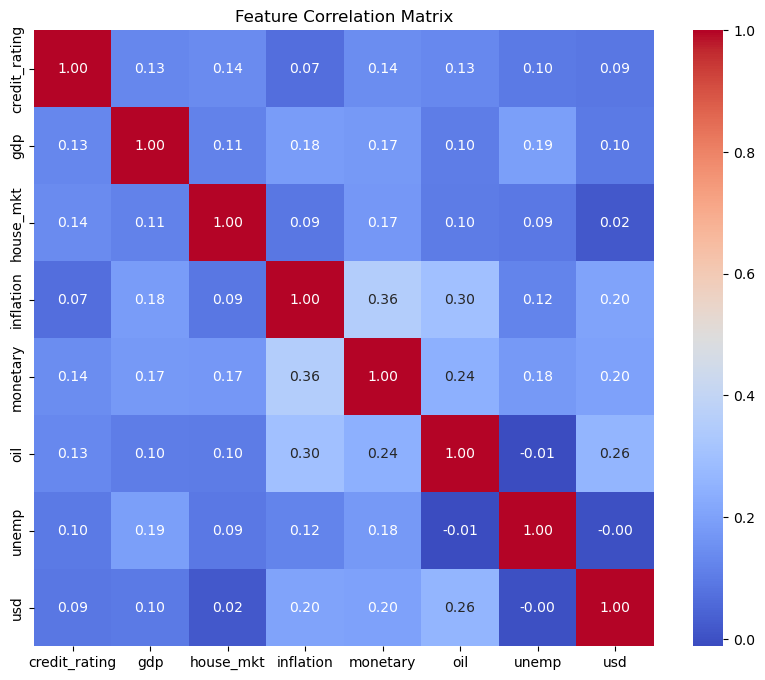

In [86]:

df = pd.DataFrame(X_mai, columns=['credit_rating', 'gdp', 'house_mkt', 'inflation', 'monetary', 'oil', 'unemp', 'usd'])  # replace 'col1', 'col2', etc. with your actual column names

corr_matrix = df.corr()

print(corr_matrix)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()
